#### Colab setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd "gdrive/My Drive/Colab Notebooks"

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from ipywidgets import IntSlider, interact, fixed

In [2]:
import common
import helpers
import prune
import statistics
from data import get_mnist, get_cifar
from experiment import Experiment
from layers import MaskedLinear, MaskedConv2d
from models import PruningModule, LeNet_20_100, LeNet_300_10, Conv2_30
from snapshots import Snapshots

## MNIST / Lenet 300-100-10

### Loading the data

In [3]:
train_batch_size = 16
test_batch_size = 1000

In [4]:
trainloader, testloader, classes = get_mnist(train_batch_size, test_batch_size)

### Defining the model

In [3]:
# Only requirement is to inherit PruningModule and to use MaskedLinear and MaskedConv2d
class LeNet_300_100(PruningModule):
    def __init__(self, bias=True):
        super(LeNet_300_100, self).__init__(bias)
        self.fc1 = MaskedLinear(28 * 28, 300, bias=bias)
        self.fc2 = MaskedLinear(300, 100, bias=bias)
        self.fc3 = MaskedLinear(100, 10, bias=bias)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
model_class = LeNet_300_100
layers = ['fc1', 'fc2', 'fc3']

### Training the model

In [7]:
epochs = 10
optim_kwargs = {'lr': 0.003, 'momentum': 0.9}
criterion = nn.CrossEntropyLoss()
model = model_class(bias=False)
optimizer = optim.SGD(model.parameters(), **optim_kwargs)

In [7]:
e = Experiment(model, criterion, optimizer, optim_kwargs)
test_accuracies = e.fit(trainloader, testloader, epochs, save_results=True)


Test set: Average loss: 2.3078, Accuracy:   1224/ 10000 (12%)

Created model directory: out/LeNet_300_100-unbiased-24_10_2019-19:17:44
Train Epoch:   1 [     0/ 60000 (0%)]	Loss: 2.297339
Train Epoch:   1 [  1600/ 60000 (3%)]	Loss: 0.981066
Train Epoch:   1 [  3200/ 60000 (5%)]	Loss: 0.464690
Train Epoch:   1 [  4800/ 60000 (8%)]	Loss: 0.543019
Train Epoch:   1 [  6400/ 60000 (11%)]	Loss: 0.118098
Train Epoch:   1 [  8000/ 60000 (13%)]	Loss: 0.626859
Train Epoch:   1 [  9600/ 60000 (16%)]	Loss: 0.292227
Train Epoch:   1 [ 11200/ 60000 (19%)]	Loss: 0.844086
Train Epoch:   1 [ 12800/ 60000 (21%)]	Loss: 0.408728
Train Epoch:   1 [ 14400/ 60000 (24%)]	Loss: 0.418998
Train Epoch:   1 [ 16000/ 60000 (27%)]	Loss: 0.150357
Train Epoch:   1 [ 17600/ 60000 (29%)]	Loss: 0.135643
Train Epoch:   1 [ 19200/ 60000 (32%)]	Loss: 0.188149
Train Epoch:   1 [ 20800/ 60000 (35%)]	Loss: 0.062210
Train Epoch:   1 [ 22400/ 60000 (37%)]	Loss: 0.164477
Train Epoch:   1 [ 24000/ 60000 (40%)]	Loss: 0.078838
Trai

Train Epoch:   4 [ 51200/ 60000 (85%)]	Loss: 0.023423
Train Epoch:   4 [ 52800/ 60000 (88%)]	Loss: 0.181666
Train Epoch:   4 [ 54400/ 60000 (91%)]	Loss: 0.010917
Train Epoch:   4 [ 56000/ 60000 (93%)]	Loss: 0.038075
Train Epoch:   4 [ 57600/ 60000 (96%)]	Loss: 0.001806
Train Epoch:   4 [ 59200/ 60000 (99%)]	Loss: 0.006408

Test set: Average loss: 0.0844, Accuracy:   9734/ 10000 (97%)

Train Epoch:   5 [     0/ 60000 (0%)]	Loss: 0.002814
Train Epoch:   5 [  1600/ 60000 (3%)]	Loss: 0.512003
Train Epoch:   5 [  3200/ 60000 (5%)]	Loss: 0.026520
Train Epoch:   5 [  4800/ 60000 (8%)]	Loss: 0.014745
Train Epoch:   5 [  6400/ 60000 (11%)]	Loss: 0.001310
Train Epoch:   5 [  8000/ 60000 (13%)]	Loss: 0.010484
Train Epoch:   5 [  9600/ 60000 (16%)]	Loss: 0.008093
Train Epoch:   5 [ 11200/ 60000 (19%)]	Loss: 0.122102
Train Epoch:   5 [ 12800/ 60000 (21%)]	Loss: 0.013142
Train Epoch:   5 [ 14400/ 60000 (24%)]	Loss: 0.007799
Train Epoch:   5 [ 16000/ 60000 (27%)]	Loss: 0.000806
Train Epoch:   5 [ 176

Train Epoch:   8 [ 44800/ 60000 (75%)]	Loss: 0.000124
Train Epoch:   8 [ 46400/ 60000 (77%)]	Loss: 0.007737
Train Epoch:   8 [ 48000/ 60000 (80%)]	Loss: 0.006459
Train Epoch:   8 [ 49600/ 60000 (83%)]	Loss: 0.000280
Train Epoch:   8 [ 51200/ 60000 (85%)]	Loss: 0.000520
Train Epoch:   8 [ 52800/ 60000 (88%)]	Loss: 0.013046
Train Epoch:   8 [ 54400/ 60000 (91%)]	Loss: 0.000862
Train Epoch:   8 [ 56000/ 60000 (93%)]	Loss: 0.012621
Train Epoch:   8 [ 57600/ 60000 (96%)]	Loss: 0.000270
Train Epoch:   8 [ 59200/ 60000 (99%)]	Loss: 0.010056

Test set: Average loss: 0.0832, Accuracy:   9791/ 10000 (98%)

Train Epoch:   9 [     0/ 60000 (0%)]	Loss: 0.000614
Train Epoch:   9 [  1600/ 60000 (3%)]	Loss: 0.231478
Train Epoch:   9 [  3200/ 60000 (5%)]	Loss: 0.001956
Train Epoch:   9 [  4800/ 60000 (8%)]	Loss: 0.003655
Train Epoch:   9 [  6400/ 60000 (11%)]	Loss: 0.000067
Train Epoch:   9 [  8000/ 60000 (13%)]	Loss: 0.002336
Train Epoch:   9 [  9600/ 60000 (16%)]	Loss: 0.000362
Train Epoch:   9 [ 112

### Look at the results

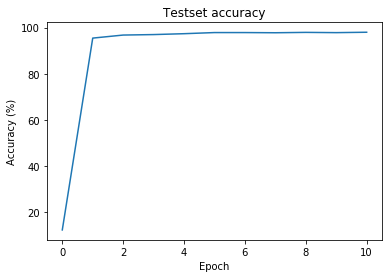

In [8]:
plt.plot(test_accuracies)
plt.title('Testset accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [5]:
output_dir = "out/LeNet_300_100-unbiased-24_10_2019-19:17:44"
s = Snapshots(output_dir, model_class)

fp_paths = {}
ip_paths = {}
norms_paths = {}
for layer in layers:
    fp_path, ip_path, norms_path = s.save_computed_metrics(layer)
    fp_paths[layer] = fp_path
    ip_paths[layer] = ip_path
    norms_paths[layer] = norms_path

Saved frame potentials to: out/LeNet_300_100-unbiased-24_10_2019-19:17:44/metrics/training/frame_potentials-fc1.npy
Saved inner products to: out/LeNet_300_100-unbiased-24_10_2019-19:17:44/metrics/training/inner_products-fc1.npy
Saved weight vector norms to: out/LeNet_300_100-unbiased-24_10_2019-19:17:44/metrics/training/weight_norms-fc1.npy
Saved frame potentials to: out/LeNet_300_100-unbiased-24_10_2019-19:17:44/metrics/training/frame_potentials-fc2.npy
Saved inner products to: out/LeNet_300_100-unbiased-24_10_2019-19:17:44/metrics/training/inner_products-fc2.npy
Saved weight vector norms to: out/LeNet_300_100-unbiased-24_10_2019-19:17:44/metrics/training/weight_norms-fc2.npy
Saved frame potentials to: out/LeNet_300_100-unbiased-24_10_2019-19:17:44/metrics/training/frame_potentials-fc3.npy
Saved inner products to: out/LeNet_300_100-unbiased-24_10_2019-19:17:44/metrics/training/inner_products-fc3.npy
Saved weight vector norms to: out/LeNet_300_100-unbiased-24_10_2019-19:17:44/metrics/t

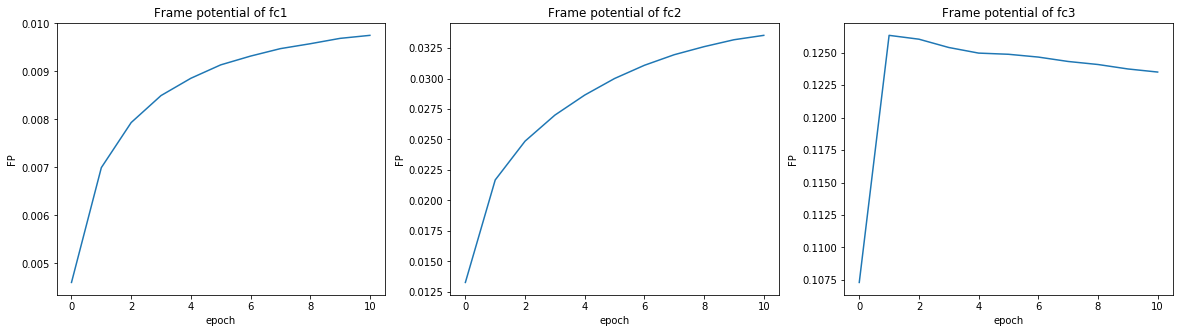

In [6]:
helpers.plot_train_fps(fp_paths, layers)

### Analysis of a layer

In [7]:
layer = layers[0]

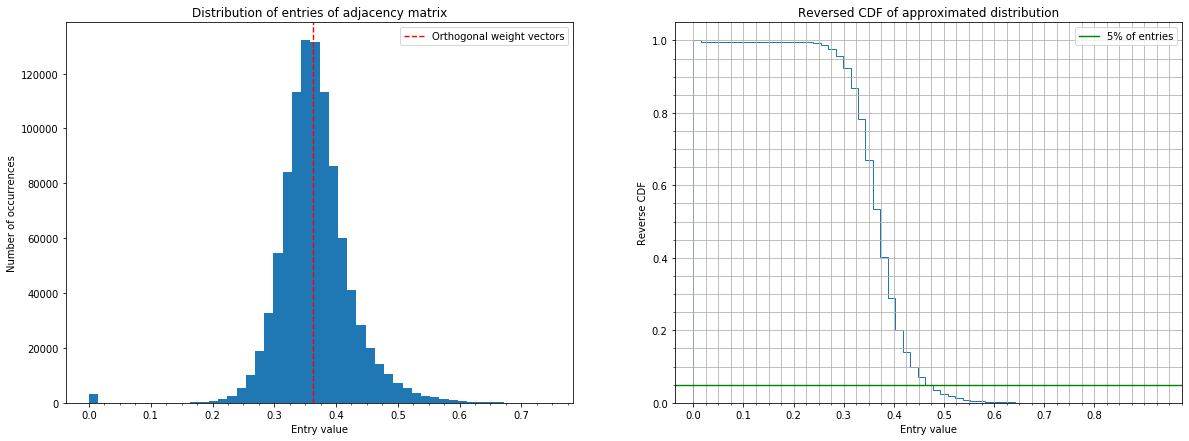

In [8]:
inner_products = np.load(ip_paths[layer])
adjacency, kernel_width = statistics.weight_dist(inner_products)

In [9]:
weight_norms = np.load(norms_paths[layer])

## CIFAR-10 / Conv-2

### Loading the data

In [ ]:
train_batch_size = 64
test_batch_size = 1000

In [ ]:
trainloader, testloader, classes = get_cifar(train_batch_size, test_batch_size)

### Defining the model

In [ ]:
class Conv2(PruningModule):
    def __init__(self, bias=True):
        super(Conv2, self).__init__(bias)
        self.conv1 = MaskedConv2d(3, 64, 3, bias=bias)
        self.conv2 = MaskedConv2d(64, 64, 3, bias=bias)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = MaskedLinear(64 * 14 * 14, 256, bias=bias)
        self.fc2 = MaskedLinear(256, 256, bias=bias)
        self.fc3 = MaskedLinear(256, 10, bias=bias)